In [1]:
import tensorflow as tf
from tensorflow import keras 
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [75]:

dataset = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/detection_dataset.npz')


origin_images, target_images, number_labels, coordinates = dataset['images'], dataset['filters'], dataset['numbers'],  dataset['coordinates']


print(origin_images.shape)
print(target_images.shape)
print(number_labels.shape)
print(coordinates.shape)


(2203, 24, 32)
(2203, 24, 32)
(2203,)
(2203, 4, 8)


In [76]:
origin_images = origin_images.reshape(2203, 24, 32, 1)
target_images = target_images.reshape(2203, 24, 32, 1)
print(origin_images.shape)
print(target_images.shape)

(2203, 24, 32, 1)
(2203, 24, 32, 1)


In [77]:
print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

origin_images = origin_images / origin_images.max()
target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

255 0
255 0
1.0 0.0
1.0 0.0


(5, 48, 32, 1)


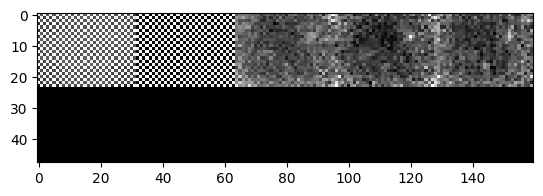

[0 0 0 0 0]
[[[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]]
[  82   83   84   85   86   87   88   89   90   91   92   93   94   95
   96   97  201  209  211  212  213  214  215  216  217  218  219  220
  221  222  223  260  261  262  263  264  265  266  267  268  269  270
  271  272  273  274  275  276  277  278  279  280  281  282  299  300
  301  302  303  304  305  306  307  308  309  382  410  411  412  413
  414  415  416  417  418  419  420  421  422  423  424  468  469  470
  471  472  473  474  475  476  477  478  479  480  481  502  503  504
  505  506  507  508  514  516  517  518  519  520  521  522  523  524
  525  526

In [78]:
imgs = np.concatenate([origin_images[0:5], target_images[0:5]], axis = 1)
print(imgs.shape)

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()
print(number_labels[0:5])

print(coordinates[0:5])

indices = np.argwhere(number_labels == 1).flatten()
print(indices)

In [ ]:
from keras.utils import to_categorical

trian_labels = to_categorical(number_labels, num_classes=5)

In [82]:
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model
# 24, 32, 1
def SupervisedAutoEncoder():
    # 이미지 입력
    inputs_image = Input(shape=(24, 32, 1))

    # Encoder 부분
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs_image)
    x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Flatten()(x)
    latent_vector = Dense(units = 32)(x)

    # Decoder 부분 (이미지 재구성)
    x = Dense(3 * 4 * 128)(latent_vector)
    x = Reshape(target_shape=(3, 4, 128))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x)
    reconstructed_image = Conv2DTranspose(filters=1, kernel_size=3, padding='same', activation='sigmoid')(x)

    # 추가적인 출력 계층 (좌표 예측)
    coords_output = Dense(4*8, activation='sigmoid')(latent_vector)  # 좌표값이 8개라고 가정
    coords_output = Reshape((4, 8))(coords_output)  # 출력의 형태를 [batch_size, 4, 8]로 변환

    return Model(inputs_image, [reconstructed_image, coords_output])

model = SupervisedAutoEncoder()


In [83]:
model = SupervisedAutoEncoder()
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 conv2d_54 (Conv2D)          (None, 12, 16, 32)           320       ['input_19[0][0]']            
                                                                                                  
 conv2d_55 (Conv2D)          (None, 6, 8, 64)             18496     ['conv2d_54[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)          (None, 3, 4, 128)            73856     ['conv2d_55[0][0]']           
                                                                                           

In [84]:
model.compile(optimizer='adam', 
              loss=['mse', 'mse'], 
              loss_weights=[1, 0.1],
              metrics = ['accuracy']
              )  # 재구성 손실과 좌표 손실을 조절하기 위해 loss_weights 사용

In [85]:
location = coordinates / 100

In [86]:
print(location[110:113])

[[[0.07 0.01 0.16 0.01 0.16 0.22 0.07 0.22]
  [0.23 0.05 0.32 0.05 0.32 0.12 0.23 0.12]
  [0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.  ]]

 [[0.06 0.01 0.16 0.01 0.16 0.18 0.06 0.18]
  [0.23 0.06 0.32 0.06 0.32 0.13 0.23 0.13]
  [0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.  ]]

 [[0.06 0.03 0.14 0.03 0.14 0.15 0.06 0.15]
  [0.22 0.06 0.32 0.06 0.32 0.13 0.22 0.13]
  [0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.  ]]]


In [87]:
hist = model.fit(
    origin_images, [target_images, location], 
    epochs=50,
    verbose = 1
)

Epoch 1/50


2023-11-02 11:57:50.384515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 2s 20ms/step - loss: 0.0381 - conv2d_transpose_75_loss: 0.0344 - reshape_33_loss: 0.0371 - conv2d_transpose_75_accuracy: 0.8326 - reshape_33_accuracy: 0.2169
Epoch 2/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0216 - conv2d_transpose_75_loss: 0.0211 - reshape_33_loss: 0.0052 - conv2d_transpose_75_accuracy: 0.8341 - reshape_33_accuracy: 0.3485
Epoch 3/50
69/69 [==============================] - 1s 16ms/step - loss: 0.0141 - conv2d_transpose_75_loss: 0.0136 - reshape_33_loss: 0.0048 - conv2d_transpose_75_accuracy: 0.8340 - reshape_33_accuracy: 0.2149
Epoch 4/50
69/69 [==============================] - 1s 16ms/step - loss: 0.0080 - conv2d_transpose_75_loss: 0.0076 - reshape_33_loss: 0.0039 - conv2d_transpose_75_accuracy: 0.8340 - reshape_33_accuracy: 0.2182
Epoch 5/50
69/69 [==============================] - 1s 16ms/step - loss: 0.0053 - conv2d_transpose_75_loss: 0.0050 - reshape_33_loss: 0.0033 - conv2d_transpose_75_accuracy

1/1 [==============================] - 0s 14ms/step


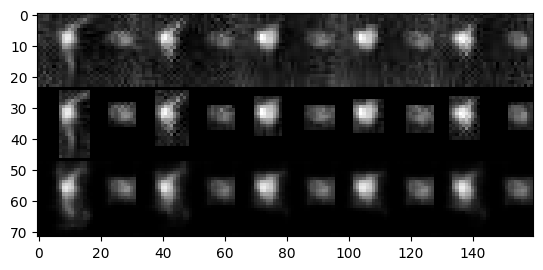

[[[ 7  1 16  1 16 22  7 22]
  [23  5 32  5 32 12 23 12]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 6  1 16  1 16 18  6 18]
  [23  6 32  6 32 13 23 13]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 6  3 14  3 14 15  6 15]
  [22  6 32  6 32 13 22 13]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 6  4 15  4 15 14  6 14]
  [23  6 32  6 32 14 23 14]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 5  3 14  3 14 16  5 16]
  [24  5 32  5 32 13 24 13]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]]


In [92]:
res = model.predict(origin_images[110:115])
images = np.concatenate([origin_images[110:115],  target_images[110:115], res[0][:6]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

plt.imshow(images, cmap='gray')
plt.show()

print(coordinates[110:115])
# print(res[1][:6])

In [116]:
def normalize_coordinates(coords, width=32, height=24):
    """
    Normalize coordinates based on width and height.

    Args:
    - coords (numpy.ndarray): The original coordinates with shape (n_samples, 4, 8).
    - width (int): The width of the image. Default is 32.
    - height (int): The height of the image. Default is 24.

    Returns:
    - numpy.ndarray: Normalized coordinates with the same shape as input.
    """

    # Check the shape of the input coordinates
    if coords.shape[-1] != 8:
        raise ValueError("The last dimension of the input coordinates should be 8.")

    # Create a normalization array
    normalization_factors = np.array([width, height, width, height, width, height, width, height])

    # Normalize the coordinates
    normalized_coords = coords / normalization_factors

    return normalized_coords


In [117]:
norm_location = normalize_coordinates(coordinates)
print(norm_location.shape)

(2203, 4, 8)


(5, 48, 32, 1)


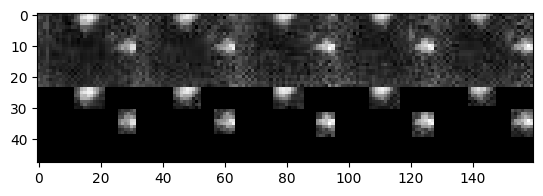

[2 2 2 2 2]
[[[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.29166667 1.         0.29166667 1.         0.58333333
   0.8125     0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.375      0.         0.625      0.         0.625      0.25
   0.375      0.25      ]
  [0.78125    0.29166667 1.         0.29166667 1.         0.58333333
   0.78125    0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.33333333 1.         0.33333333 1.         0.625
   0.8125     0.625     ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  

In [120]:
imgs = np.concatenate([origin_images[1000:1005], target_images[1000:1005]], axis = 1)
print(imgs.shape)

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()
print(number_labels[1000:1005])

print(norm_location[1000:1005])

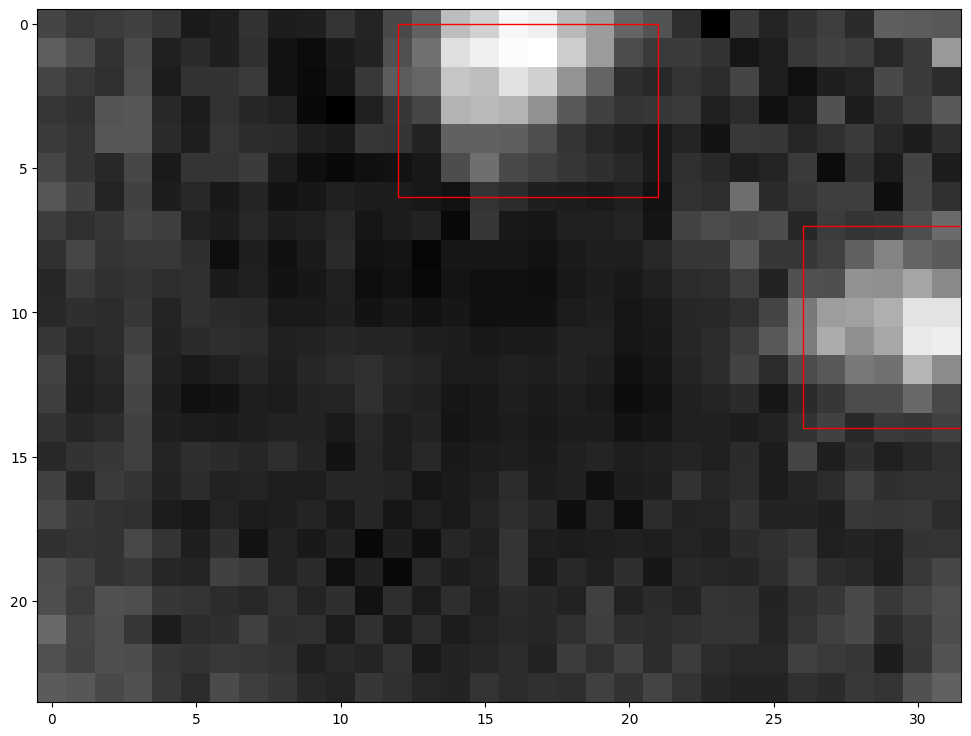

In [128]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_boxes_on_image(image, normalized_coords, width=32, height=24):
    """
    Draw bounding boxes on the given image using normalized coordinates.

    Args:
    - image (numpy.ndarray): The input image with shape (height, width).
    - normalized_coords (numpy.ndarray): The normalized coordinates with shape (1, 4, 8).
    - width (int): The width of the image. Default is 32.
    - height (int): The height of the image. Default is 24.
    """

    # Remove the first dimension from normalized_coords
    normalized_coords = normalized_coords.squeeze()

    # Denormalize the coordinates
    denormalized_coords = normalized_coords * [width, height, width, height, width, height, width, height]

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Display the image
    ax.imshow(image[0, :, :, 0], cmap='gray')

    # Loop over each set of coordinates and draw the bounding box
    for coord in denormalized_coords:
        # Extract coordinates for the bounding box
        top_left_x, top_left_y, top_right_x, top_right_y, bottom_right_x, bottom_right_y, bottom_left_x, bottom_left_y = coord
        
        # Create a rectangle patch using top left and bottom right coordinates
        rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the axis
        ax.add_patch(rect)

    plt.show()




draw_boxes_on_image(origin_images[1000:1001], norm_location[1000:1001])


In [125]:
print(norm_location[1000:1001].shape)
print(norm_location[1000:1001])


(1, 4, 8)
[[[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.29166667 1.         0.29166667 1.         0.58333333
   0.8125     0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]]


In [150]:
from keras.layers import GRU, Dense, Input, Conv2D, Reshape
from keras.models import Model

def SupervisedAutoEncoder():
    # 이미지 입력
    inputs_image = Input(shape=(24, 32, 1))

    # Encoder 부분
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs_image)
    x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Flatten()(x)
    latent_vector = Dense(units = 32)(x)

    # Decoder 부분 (이미지 재구성)
    x = Dense(3 * 4 * 128)(latent_vector)
    x = Reshape(target_shape=(3, 4, 128))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x)
    reconstructed_image = Conv2DTranspose(filters=1, kernel_size=3, padding='same', activation='sigmoid')(x)
    
    # 추가적인 출력 계층 (좌표 예측)
    coords_output = Dense(4*8, activation='sigmoid')(latent_vector)  # 좌표값이 8개라고 가정
    coords_output = Reshape((4, 8))(coords_output)  # 출력의 형태를 [batch_size, 4, 8]로 변환

    return Model(inputs_image, [reconstructed_image, coords_output])

def Sequence(SupervisedAutoEncoder):
    reconstruction_input = Input(shape=(24, 32, 1))
    coords_input = Input(shape=(4, 8))
    x = model.layers[-1].output
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(reconstruction_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=(4, 4), activation='relu', padding='same')(x) 

    x = Reshape((6, 8*64))(x)  # 6x(8*64) 형태로 변환

    # coords_input의 정보를 압축하고 적절한 형태로 변환
    compressed_coords = Dense(6*8, activation='relu')(Flatten()(coords_input))
    reshaped_coords = Reshape((6, 8))(compressed_coords)
    
    x = concatenate([x, reshaped_coords], axis=-1)


    # GRU 계층
    x = GRU(64, return_sequences=True)(x)
    x = GRU(64)(x)

    # 사람 수 예측 계층
    number_output = Dense(5, activation='softmax', name='number_output')(x)

    # 좌표값 예측 계층 (32개의 값을 예측합니다. 4명 * 8개의 좌표값)
    coords_output = Dense(4*8, activation='linear', name='coords_output')(x)


    sequence_model = Model(inputs=[reconstruction_input, coords_input], outputs=[number_output, coords_output])
    return sequence_model

In [151]:
def IntegratedModel(SupervisedAutoEncoder, Sequence):
    # 입력 이미지
    input_image = Input(shape=(24, 32, 1))
    
    # SupervisedAutoEncoder를 통과
    reconstructed_image, predicted_coords = SupervisedAutoEncoder(input_image)
    
    # Sequence 모델을 통과
    number_output, coords_output = Sequence([reconstructed_image, predicted_coords])
    
    return Model(inputs=input_image, outputs=[number_output, coords_output])

# 모델 생성
supervised_autoEncoder = SupervisedAutoEncoder()
sequence = Sequence(supervised_autoEncoder)
integrated_model = IntegratedModel(supervised_autoEncoder, sequence)


In [155]:
integrated_model.summary()
supervised_autoEncoder.summary()
sequence.summary()

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_52 (InputLayer)       [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 model_37 (Functional)       [(None, 24, 32, 1),          433729    ['input_52[0][0]']            
                              (None, 4, 8)]                                                       
                                                                                                  
 model_38 (Functional)       [(None, 5),                  197205    ['model_37[0][0]',            
                              (None, 32)]                            'model_37[0][1]']            
                                                                                           

model_31/number_output/Softmax:0
model_31/coords_output/BiasAdd:0
